# WebScraping Ottawa/Gatineau Rent
## Author : Saif Ahmed

Summary: The goal of this project is to use webscraping to analyze rent price for different neighbourhoods in the city of Ottawa/Gatineau. Daily Craigslist rental listings for rooms/shares and apartment categories for the city of Ottawa/Gatineau can be scraped to determine change overtime. 

Based on the analysis, the conclusions dervied are:

-  The lowest rent was observed in Cyriville neighbourhood and most expensive rent was observed in Half Moon Bay. 
-  For 1-2 bedroom under 2500sqft rent can be around 1500-2000CAD and >2 bedroom houses rent can be around 2300-3000CAD
- Average rent listing in Ottawa/Gatineau is around 1250-1500CAD

In [1]:
#import get to call a get request on the site
from requests import get

#get the first page of the east bay housing prices
response = get('https://ottawa.craigslist.org/search/apa?hasPic=1&availabilityMode=0') #get rid of those lame-o's that post a housing option without a pic using their filter

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 120 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [2]:
post_one = posts[0]
print(post_one)

<li class="result-row" data-pid="7455908827">
<a class="result-image gallery" data-ids="3:00Z0Z_eKk5eEe8919z_0t20jg,3:00X0X_bLpwiWJwd6z_0t20jd,3:00606_9CwASk86ezzz_0t20jm,3:00z0z_aj0aIRzBRD6z_0t20jc,3:00c0c_kp5LjdGmh2Cz_0t20iO,3:00505_8eV835R1zp8z_0t20jm,3:00z0z_gf4oGterONFz_0t20jm,3:00h0h_4D0TIqtWqQnz_0t20jm,3:00505_kaUoHRIrfjEz_0t20jm,3:00m0m_klfJqw2E4lZz_0t20jm,3:01212_kzoMGwNEgEz_0t20jm,3:00e0e_i2pBMgLHp9Rz_0t20jm,3:00M0M_a6yMxlwg43Oz_0t20jm,3:00Q0Q_gfyWXW8kxbLz_0t20jm,3:00A0A_iHSKVr6a4M3z_0t20jm,3:00o0o_axkc3eajMflz_0t20jm,3:00M0M_lA7Hrr3PKUnz_0t20jm,3:00E0E_f2FAOvPAi8Tz_0t20jm,3:00000_cYldrKz8QWaz_0t20jm,3:00h0h_cGzl8dq0EiIz_0t20jm,3:00t0t_3PchFAUkuxsz_0t20jm,3:00Z0Z_aK6OW2rAqqnz_0t20iY,3:00Y0Y_94sSb6T2rPNz_0t20iQ,3:00R0R_jjmdRWOmY5Sz_0t20jm" href="https://ottawa.craigslist.org/apa/d/nepean-newly-built-end-unit-townhome/7455908827.html">
<span class="result-price">$2,200</span>
</a>
<div class="result-info">
<span class="icon icon-star" role="button">
<span class="screen-reader-t

In [3]:
#grab the price of the first post
post_one_price = post_one.find('span', class_= 'result-price').text.split()[0]
print(post_one_price)

$2,200


In [4]:
#grab the time of the post in datetime format to save on cleaning efforts
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']
print(post_one_datetime)

2022-03-11 10:53


In [5]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']

#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text
print(post_one_title_text)

Newly Built End Unit Townhome - 4Bed/2.5Bath - Barrhaven ($2200)


In [6]:
#grabs the whole segment of housing details. We will need missing value handling in the loop as this kind of detail is not common in posts
#the text can be split, and we can use indexing to grab the elements we want. number of bedrooms is the first element.
#sqft is the third element

post_one_num_bedrooms = post_one.find('span', class_ = 'housing').text.split()[0]

print(post_one_num_bedrooms)


4br


In [7]:
post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[2][:-3] #cleans the ft2 at the end

print(post_one_sqft)

1850


In [8]:
#the neighborhood is grabbed by finding the span class 'result-hood' and pulling the text element from that
post_one_hood = posts[0].find('span', class_='result-hood').text[2:-1]
print(post_one_hood)

376 Aphelion Cr  


In [9]:
#Web scrape Ottawa Apartments
#build out the loop
from time import sleep
import re
from random import randint 
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 192)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    response = get('https://ottawa.craigslist.org/search/apa?' 
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "&hasPic=1"
                   + "&availabilityMode=0")

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text[2:-1]
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = str(post.a.text.strip().replace("$", ""))
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

    print("\n")

print("Scrape complete!")


Page 1 scraped successfully!


Scrape complete!


In [10]:
import pandas as pd
Ott_apts = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})
Ott_apts['price']=Ott_apts['price'].str.replace(',','')
print(Ott_apts.info())
Ott_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   posted           120 non-null    object 
 1   neighborhood     120 non-null    object 
 2   post title       120 non-null    object 
 3   number bedrooms  115 non-null    object 
 4   sqft             51 non-null     float64
 5   URL              120 non-null    object 
 6   price            120 non-null    object 
dtypes: float64(1), object(6)
memory usage: 6.7+ KB
None


,posted,neighborhood,post title,number bedrooms,sqft,URL,price
0,2022-03-11 10:53,376 Aphelion Cr,Newly Built End Unit Townhome - 4Bed/2.5Bath -...,4,1850.0,https://ottawa.craigslist.org/apa/d/nepean-new...,2200
1,2022-03-11 10:29,555 Gilmour Street,Large 2BR+Den Heritage Style with private balc...,2,1000.0,https://ottawa.craigslist.org/apa/d/ottawa-lar...,1645
2,2022-03-11 08:59,Aylmer,"83 porc-épic, NOUVELLE maison duplex 3 chambre...",3,NaN,https://ottawa.craigslist.org/apa/d/aylmer-nor...,2195
3,2022-03-11 08:59,Secteur des Tremble,42 Impasse des Lilas #8 condo 3 Chambres 1er J...,3,1200.0,https://ottawa.craigslist.org/apa/d/hull-south...,1695
4,2022-03-11 08:59,Alymer,310 Maurice-Martel – MAISON 4 chambres (Aylmer...,4,NaN,https://ottawa.craigslist.org/apa/d/aylmer-nor...,2295
5,2022-03-11 08:59,Aylmer,"rue de Bruxelles ,condo 1 chambre disponible 1...",1,NaN,https://ottawa.craigslist.org/apa/d/aylmer-nor...,1095
6,2022-03-11 08:59,Ottawa,949 Bronson- House – 3 bedrooms – Available Ma...,3,NaN,https://ottawa.craigslist.org/apa/d/ottawa-949...,2595
7,2022-03-11 08:31,Ottawa,Brand New Condo for rent - Clairdge Ottawa - Icon,1,730.0,https://ottawa.craigslist.org/apa/d/ottawa-bra...,2100
8,2022-03-10 21:35,"Hintonburg, Ottawa",Bright and Spacious Condo Available April 15 o...,1,664.0,https://ottawa.craigslist.org/apa/d/ottawa-bri...,1800
9,2022-03-10 19:14,,"3BR & 1Bath, BSMT APT, May 1, 2min to Algonqui...",3,1000.0,https://ottawa.craigslist.org/apa/d/nepean-3br...,1737


In [11]:
#Data cleaning
Ott_apts = Ott_apts.drop_duplicates(subset='URL')
len(Ott_apts.drop_duplicates(subset='URL'))

#make the number bedrooms to a float (since np.nan is a float too)
Ott_apts['number bedrooms'] = Ott_apts['number bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to be able to work with it
from datetime import datetime

Ott_apts['posted'] = pd.to_datetime(Ott_apts['posted'])

#Looking at what neighborhoods there are with eb_apts['neighborhood'].unique() allowed me to see what
#I needed to deal with in terms of cleaning those.

#remove the parenthesis from the left and right of the neighborhoods
Ott_apts['neighborhood'] = Ott_apts['neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))

#titlecase them
Ott_apts['neighborhood'] = Ott_apts['neighborhood'].str.title()

#just take the first name of the neighborhood list, splitting on the '/' delimiter
Ott_apts['neighborhood'] = Ott_apts['neighborhood'].apply(lambda x: x.split('/')[0])

#fix one-offs that
Ott_apts['neighborhood'].replace('Sandy Hill,Ottawa U, Downtown','Sandy Hill', inplace=True)

#remove whitespaces
Ott_apts['neighborhood'] = Ott_apts['neighborhood'].apply(lambda x: x.strip())

#save the clean data
Ott_apts.to_csv("Ott_apts_Mar_5_22_clean.csv", index=False)

In [12]:
#Exploratory Data Analysis
Ott_apts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   posted           120 non-null    datetime64[ns]
 1   neighborhood     120 non-null    object        
 2   post title       120 non-null    object        
 3   number bedrooms  115 non-null    float64       
 4   sqft             51 non-null     float64       
 5   URL              120 non-null    object        
 6   price            120 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 7.5+ KB


In [13]:
import pandas as pd, numpy as np
Ott_apts = pd.read_csv("Ott_apts_Mar_5_22_clean.csv")

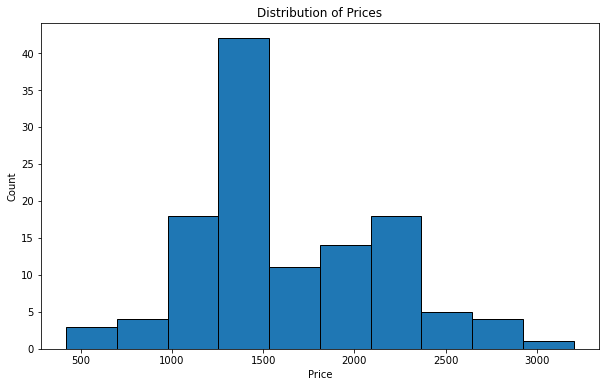

In [14]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.hist(Ott_apts['price'], edgecolor='black');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Prices");

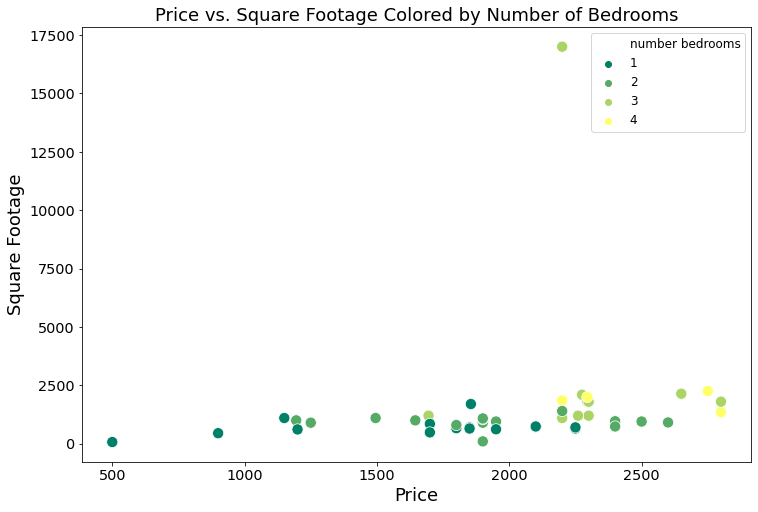

In [15]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='price', y='sqft', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=Ott_apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

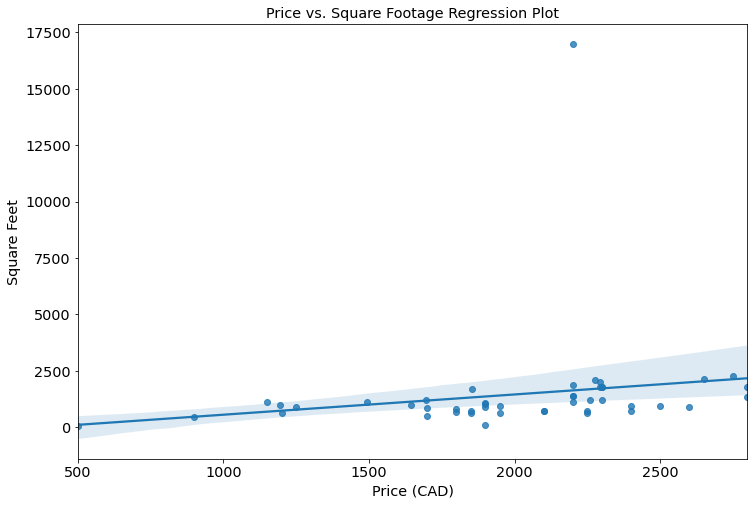

In [16]:
plt.figure(figsize=(12, 8))
sns.regplot(x='price', y='sqft', data=Ott_apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (CAD)");
plt.ylabel("Square Feet");

In [17]:
Ott_apts.corr()

,number bedrooms,sqft,price
number bedrooms,1.000000,0.279846,0.640718
sqft,0.279846,1.000000,0.214800
price,0.640718,0.214800,1.000000


In [18]:
Ott_apts.groupby('neighborhood').mean()

,number bedrooms,sqft,price
neighborhood,,,
101 Richmond Rd #319,2.000000,950.000000,2500.000000
11 River Road,2.000000,900.000000,1250.000000
"130 Besserer St #1801, Ottawa",1.000000,650.000000,1850.000000
1322 Mcwatters Road,2.000000,NaN,1600.000000
1660 Baseline Road,1.000000,NaN,699.000000
169 Lisgar Street,NaN,NaN,1475.000000
2138 Saunderson Dr,3.000000,1200.000000,2300.000000
"2138 Saunderson Dr, Ottawa",2.000000,100.000000,1900.000000
259 Joffre Belanger Way,2.000000,NaN,1425.000000


In [19]:
Ott_apts['neighborhood'].replace('Stittsville, Ontario', 'Stittsville', inplace=True)
Ott_apts['neighborhood'].replace('Sandy Hill - Somerset St East', 'Sandy Hill', inplace=True)
Ott_apts['neighborhood'].replace('60 Minutes From Ottawa In Douglas On...15 Mins From Renfrew', 'Douglas', inplace=True)
Ott_apts['neighborhood'].replace('Ontario', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('384 Maclaren Street' , 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('2929 Carling Avenue', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('Downtown', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('11 River Road', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('Ottawa', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('Gatineau  Hull', 'Gatineau', inplace=True)
Ott_apts['neighborhood'].replace('Hull- Gatineau', 'Gatineau', inplace=True)
Ott_apts['neighborhood'].replace('324 Laurier Ave, Ottawa', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('Kanata, Ottawa', 'Kanata', inplace=True)
Ott_apts['neighborhood'].replace('1660 Baseline Road', 'Nepean', inplace=True)
Ott_apts['neighborhood'].replace('67 Marquette Ave., Ottawa', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('350 Macarthur', 'Vanier', inplace=True)
Ott_apts['neighborhood'].replace('259 Joffre Belanger Way', 'Vanier', inplace=True)
Ott_apts['neighborhood'].replace('335 Maclaren', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('169 Lisgar Street', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('Ottawa: New Edinburgh', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('112 Florence Street', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('1322 Mcwatters Road', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('360 Frank Street', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('130 Besserer St #1801, Ottawa', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('354 Gladstone Ave #205', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('101 Richmond Rd #319', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('360 Patricia Ave #819', 'Ottawa Downtown', inplace=True)
Ott_apts['neighborhood'].replace('268 Citiplace Dr, Ottawa', 'Nepean', inplace=True)

In [20]:
#sort price to find cheapest
Ott_apts.groupby('neighborhood').mean()['price'].sort_values()

neighborhood
Cyrville                       500.000000
Gatineau                      1356.666667
Sandy Hill                    1400.000000
Vanier                        1423.076923
Centretown                    1450.000000
Nepean                        1599.666667
555 Gilmour Street            1645.000000
Aylmer                        1645.000000
Lowertown                     1650.000000
Ottawa Downtown               1664.173913
Secteur Des Tremble           1695.000000
Hintonburg, Ottawa            1800.000000
Douglas                       1900.000000
Byward Market                 1900.000000
2138 Saunderson Dr, Ottawa    1900.000000
Denholm                       1900.000000
Ottawa  Sandy-Hill Area       1950.000000
Carson Meadows                2000.000000
Stittsville                   2173.333333
Barrhaven                     2200.000000
Ottawa, On                    2200.000000
376 Aphelion Cr               2200.000000
Kanata                        2265.000000
Alymer               

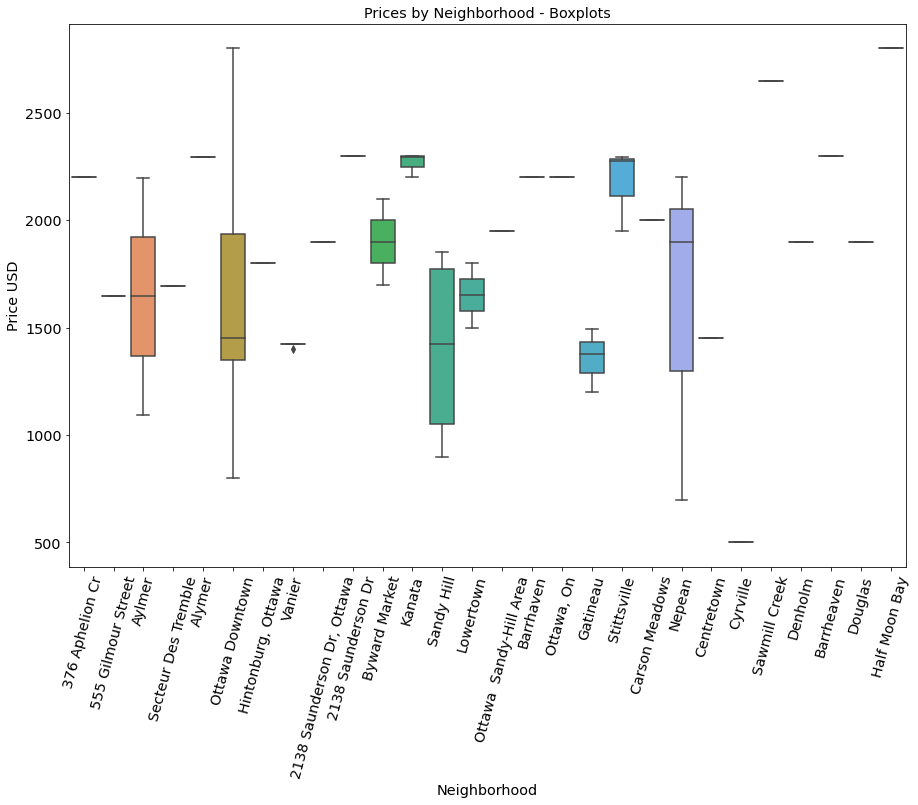

In [21]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='neighborhood', y='price', data=Ott_apts)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");